## Test out UGRID-0.9 compliant unstructured grid model datasets with PYUGRID

In [28]:
%matplotlib inline

In [29]:
import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
import datetime as dt
import netCDF4

In [30]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial, MapQuestOSM, OSM

In [31]:
import iris
import pyugrid

In [32]:
iris.FUTURE.netcdf_promote = True

In [33]:
#ADCIRC
#url =  'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/UND_ADCIRC/Hurricane_Ike_3D_final_run_with_waves'
#FVCOM
#url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
#SELFE
#url = 'http://comt.sura.org/thredds/dodsC/data/comt_1_archive/inundation_tropical/VIMS_SELFE/Hurricane_Ike_2D_final_run_with_waves'

In [34]:
# UMASSD/SMAST Water Quality FVCOM Simulation for MWRA
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/wq'
var = 'Dissolved oxygen'  # use long_name because DO has no standard_name in this dataset
levs = np.arange(5.,15.,.25)   # contour levels for plotting
klev = 0   # level 0 is top in FVCOM

In [35]:
# UMASSD/SMAST FVCOM Simulations in support of Water Quality for MWRA
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/mwra/fvcom'
var = 'sea_water_salinity'    # use standard_name if it exists
levs = np.arange(28.,33.5,.1)   # contour levels for plotting
klev = 0   # level 0 is top in FVCOM

In [36]:
# Desired time for snapshot
# ....right now (or some number of hours from now) ...
start = dt.datetime.utcnow() + dt.timedelta(hours=6)
# ... or specific time (UTC)
start = dt.datetime(1998,3,2,15,0,0)

In [37]:
nc = netCDF4.Dataset(url)
#print nc.variables.keys()  # list variables
#nc.variables['DO']  # show variable with attributes

In [38]:
cube = iris.load_cube(url,var)    # Iris uses the standard_name or long_name to access variables

/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:552: UserWarning: Missing CF-netCDF formula term variable u'depth', referenced by netCDF variable u'siglev'
  warnings.warn(message % (variable_name, nc_var_name))
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'v': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'ww': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn(msg)
/home/usgs/miniconda/envs/ioos/lib/python2.7/site-packages/iris/fileformats/cf.py:1006: UserWarning: Ignoring variable u'siglay' referenced by variable u'u': Dimensions (u'siglay', u'node') do not span (u'time', u'siglay', u'nele')
  warnings.warn

In [39]:
# Get desired time step  
time_var = nc['time']
itime = netCDF4.date2index(start,time_var,select='nearest')

In [40]:
ug = pyugrid.UGrid.from_ncfile(url)

print "There are %i nodes"%ug.nodes.shape[0]
print "There are %i faces"%ug.faces.shape[0]

There are 5472 nodes
There are 9739 faces


In [41]:
print cube

sea_water_salinity / (1)            (time: 131611; -- : 30; -- : 5472)
     Dimension coordinates:
          time                           x            -        -
     Auxiliary coordinates:
          sea_surface_height_above_geoid x            -        x
          Sigma Layers                   -            x        x
          latitude                       -            -        x
          longitude                      -            -        x
          sea_floor_depth_below_geoid    -            -        x
     Attributes:
          Conventions: CF-1.0, UGRID-0.9
          CoordinateProjection: init=nad83:1802
          CoordinateSystem: Cartesian
          GroundWater_Forcing: FVCOM variable GroundWater forcing:
FILE NAME:gom_gwater_forcing.nc
SOURCE:FVCOM...
          NCO: 4.4.4
          River_Forcing: THERE ARE 13 RIVERS IN THIS MODEL.
RIVER INFLOW IS ON THE nodes WHERE TEMPERATURE...
          Surface_Heat_Forcing: FVCOM variable surface heat forcing file:
FILE NAME:wrf_hnd20

In [42]:
cube.mesh = ug
cube.mesh_dimension = 1  # (0:time,1:node)

In [43]:
lon = cube.mesh.nodes[:,0]
lat = cube.mesh.nodes[:,1]
nv = cube.mesh.faces

In [44]:
triang = tri.Triangulation(lon,lat,triangles=nv)

In [45]:
zcube = cube[itime, klev, :]

In [46]:
print zcube.data.min()
print zcube.data.max()

0.0
32.2619


try simple plot

<matplotlib.tri.tricontour.TriContourSet instance at 0x7fd8c8b281b8>

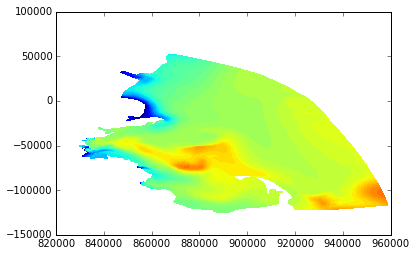

In [47]:
plt.tricontourf(triang, zcube.data, levels=levs)

Try more complex cartopy plot

In [48]:
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-90, -60, 5, 50])
#ax.coastlines('10m')
plt.tricontourf(triang, zcube.data, levels=levs)
plt.colorbar(fraction=0.035, pad=0.04)
plt.tricontour(triang, zcube.data, colors='k',levels=levs)
tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: Elevation (m): %s' % (zcube.attributes['title'],tstr));

ValueError: need at least one array to concatenate

## Try to plot using tiled background

In [ ]:


projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,12))
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=projection)

ax.set_extent([-71.5, -70, 41.5, 43], projection)
ax.add_image(tiler, 8, zorder=0)

cs = ax.tricontourf(triang, zcube.data, levels=levs, zorder=1)
ax.tricontour(triang, zcube.data, colors='k', levels=levs, zorder=2)
fig.colorbar(cs)

tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_title('%s: Oxygen: %s' % (zcube.attributes['title'],tstr));



In [ ]:
#geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,12))
tiler = MapQuestOpenAerial()
ax = plt.axes(projection=tiler.crs)

#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-71.5, -70, 41.5, 43],projection)
ax.add_image(tiler, 8, zorder=0)

#ax.coastlines()
plt.tricontourf(triang, zcube.data, levels=levs,zorder=1)
plt.colorbar()
plt.tricontour(triang, zcube.data, colors='k',levels=levs,zorder=2)
tvar = cube.coord('time')
tstr = tvar.units.num2date(tvar.points[itime])
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title('%s: Oxygen: %s' % (zcube.attributes['title'],tstr));

In [49]:
cube.coord(axis="x")

AuxCoord(array([ 867630.,  869180.,  870980., ...,  822932.,  823078.,  822723.], dtype=float32), standard_name=u'longitude', units=Unit('degrees'), long_name=u'Longitude', var_name='lon', attributes={'grid': 'Bathymetry_Mesh'})